In [1]:
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from keras.layers import Attention
from keras.models import Model
from keras.layers import LSTM, Dense, Input, ReLU, Add
from keras.optimizers import Adam
from tensorflow.keras.losses import logcosh, mse
from keras.callbacks import EarlyStopping
from pandas.tseries.offsets import BDay  # BDay untuk menghindari weekend

In [2]:
data=pd.read_csv('variabel lain/sentimentfedrate.csv')
data

,Judul Berita,Nama Media,Waktu Terbit,Link Berita,Clean Text,Detected Language,confidence,stopword,sentiment
0,Chinese tech stocks rise in last trading sessi...,Financial Times,31 Dec 2021,https://www.ft.com/content/be4b6544-a999-457f-...,chinese tech stocks rise in last trading sessi...,en,1.0,chinese tech stocks rise last trading session ...,positive
1,Stocks notch big yearly gain despite ending 20...,PBS,31 Dec 2021,https://www.pbs.org/newshour/economy/stocks-no...,stocks notch big yearly gain despite ending o...,en,1.0,stocks notch big yearly gain despite ending we...,positive
2,"Stocks surged in 2021, as Wall Street rolled i...",CNN,31 Dec 2021,https://www.cnn.com/2021/12/31/investing/dow-s...,stocks surged in as wall street rolled its ey...,en,1.0,stocks surged wall street rolled eyes covid,positive
3,U.S. 10-year Treasury yield finishes 2021 abov...,CNBC,31 Dec 2021,https://www.cnbc.com/2021/12/31/us-treasury-yi...,us treasury yield finishes above,en,1.0,us treasury yield finishes,neutral
4,Extend GST compensation payment by 5 years: St...,mint,31 Dec 2021,https://www.livemint.com/news/india/extend-gst...,extend gst compensation payment by years stat...,en,1.0,extend gst compensation payment years states t...,neutral
...,...,...,...,...,...,...,...,...,...
21748,Gold falls as stronger US jobs data shrinks ho...,MSN,2024-10-04,https://www.msn.com/en-us/money/markets/gold-f...,gold falls as stronger us jobs data shrinks ho...,en,1.0,gold falls stronger us jobs data shrinks hopes...,negative
21749,"September Jobs Data Could Delay Fed Rate Cuts,...",Coin Edition,2024-10-04,https://coinedition.com/id/september-jobs-data...,september jobs data could delay fed rate cuts ...,en,1.0,september jobs data could delay fed rate cuts ...,negative
21750,"Steady Unemployment, Moderate Job Growth May H...",International Business Times,2024-10-04,https://www.ibtimes.com/steady-unemployment-mo...,steady unemployment moderate job growth may ha...,en,1.0,steady unemployment moderate job growth may ha...,negative
21751,"Dollar Soars as U.S. Job Market Surges, Gold D...",Devdiscourse,2024-10-04,https://www.devdiscourse.com/article/business/...,dollar soars as us job market surges gold dips...,en,1.0,dollar soars us job market surges gold dips am...,negative


In [3]:
# Menghitung jumlah data berdasarkan kelas sentimen
sentiment_counts = data['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'Count']

# Membuat visualisasi bar chart menggunakan Plotly
fig = px.bar(sentiment_counts, x='sentiment', y='Count', color='sentiment', 
             title='Total Count of Each Sentiment Class', 
             labels={'Count':'Total', 'Sentiment':'Sentiment Class'}, 
             height=400, width=600)

# Menampilkan grafik
fig.show()

In [4]:
# Filter data untuk setiap sentimen
negative_data = data[data['sentiment'] == 'negative']
positive_data = data[data['sentiment'] == 'positive']
neutral_data = data[data['sentiment'] == 'neutral']

# Menghitung jumlah berita per media untuk masing-masing sentimen
media_negative_counts = negative_data['Nama Media'].value_counts().reset_index()
media_positive_counts = positive_data['Nama Media'].value_counts().reset_index()
media_neutral_counts = neutral_data['Nama Media'].value_counts().reset_index()

# Menamai kolom hasil perhitungan
media_negative_counts.columns = ['Nama Media', 'Jumlah Berita Negatif']
media_positive_counts.columns = ['Nama Media', 'Jumlah Berita Positif']
media_neutral_counts.columns = ['Nama Media', 'Jumlah Berita Netral']

# Menampilkan hanya 10 media teratas
top_10_negative_media = media_negative_counts.head(10)
top_10_positive_media = media_positive_counts.head(10)
top_10_neutral_media = media_neutral_counts.head(10)

# Membuat visualisasi bar chart untuk Sentimen Negatif
fig_neg = px.bar(top_10_negative_media, 
                 x='Nama Media', 
                 y='Jumlah Berita Negatif', 
                 title='Top 10 Media yang Memberitakan Sentimen Negatif',
                 labels={'Nama Media':'Media', 'Jumlah Berita Negatif':'Jumlah Berita'},
                 color='Nama Media',
                 height=500)

# Membuat visualisasi bar chart untuk Sentimen Positif
fig_pos = px.bar(top_10_positive_media, 
                 x='Nama Media', 
                 y='Jumlah Berita Positif', 
                 title='Top 10 Media yang Memberitakan Sentimen Positif',
                 labels={'Nama Media':'Media', 'Jumlah Berita Positif':'Jumlah Berita'},
                 color='Nama Media',
                 height=500)

# Membuat visualisasi bar chart untuk Sentimen Netral
fig_neutral = px.bar(top_10_neutral_media, 
                     x='Nama Media', 
                     y='Jumlah Berita Netral', 
                     title='Top 10 Media yang Memberitakan Sentimen Netral',
                     labels={'Nama Media':'Media', 'Jumlah Berita Netral':'Jumlah Berita'},
                     color='Nama Media',
                     height=500)

# Menampilkan plot
fig_neg.show()
fig_pos.show()
fig_neutral.show()

In [5]:
data['Waktu Terbit'] = data['Waktu Terbit'].apply(
    lambda x: pd.to_datetime(x.replace('Sept', 'Sep'), format='mixed') if isinstance(x, str) else x
)

data

,Judul Berita,Nama Media,Waktu Terbit,Link Berita,Clean Text,Detected Language,confidence,stopword,sentiment
0,Chinese tech stocks rise in last trading sessi...,Financial Times,2021-12-31,https://www.ft.com/content/be4b6544-a999-457f-...,chinese tech stocks rise in last trading sessi...,en,1.0,chinese tech stocks rise last trading session ...,positive
1,Stocks notch big yearly gain despite ending 20...,PBS,2021-12-31,https://www.pbs.org/newshour/economy/stocks-no...,stocks notch big yearly gain despite ending o...,en,1.0,stocks notch big yearly gain despite ending we...,positive
2,"Stocks surged in 2021, as Wall Street rolled i...",CNN,2021-12-31,https://www.cnn.com/2021/12/31/investing/dow-s...,stocks surged in as wall street rolled its ey...,en,1.0,stocks surged wall street rolled eyes covid,positive
3,U.S. 10-year Treasury yield finishes 2021 abov...,CNBC,2021-12-31,https://www.cnbc.com/2021/12/31/us-treasury-yi...,us treasury yield finishes above,en,1.0,us treasury yield finishes,neutral
4,Extend GST compensation payment by 5 years: St...,mint,2021-12-31,https://www.livemint.com/news/india/extend-gst...,extend gst compensation payment by years stat...,en,1.0,extend gst compensation payment years states t...,neutral
...,...,...,...,...,...,...,...,...,...
21748,Gold falls as stronger US jobs data shrinks ho...,MSN,2024-10-04,https://www.msn.com/en-us/money/markets/gold-f...,gold falls as stronger us jobs data shrinks ho...,en,1.0,gold falls stronger us jobs data shrinks hopes...,negative
21749,"September Jobs Data Could Delay Fed Rate Cuts,...",Coin Edition,2024-10-04,https://coinedition.com/id/september-jobs-data...,september jobs data could delay fed rate cuts ...,en,1.0,september jobs data could delay fed rate cuts ...,negative
21750,"Steady Unemployment, Moderate Job Growth May H...",International Business Times,2024-10-04,https://www.ibtimes.com/steady-unemployment-mo...,steady unemployment moderate job growth may ha...,en,1.0,steady unemployment moderate job growth may ha...,negative
21751,"Dollar Soars as U.S. Job Market Surges, Gold D...",Devdiscourse,2024-10-04,https://www.devdiscourse.com/article/business/...,dollar soars as us job market surges gold dips...,en,1.0,dollar soars us job market surges gold dips am...,negative


In [7]:
data.isnull().sum()

Judul Berita         0
Nama Media           0
Waktu Terbit         0
Link Berita          0
Clean Text           2
Detected Language    0
confidence           0
stopword             2
sentiment            0
dtype: int64

In [8]:
missing = data[data['Clean Text'].isnull()]
missing

,Judul Berita,Nama Media,Waktu Terbit,Link Berita,Clean Text,Detected Language,confidence,stopword,sentiment
15540,How+to+prepare+for+the+Fed%E2%80%99s+forthcomi...,The Journal Record,2024-08-27,https://journalrecord.com/2024/08/how-to-prepa...,NaN,en,1.0,NaN,positive
17309,What+effect+will+a+lower+Fed+rate+have+on+auto...,The Journal Record,2024-09-09,https://journalrecord.com/2024/09/what-effect-...,NaN,en,1.0,NaN,neutral


In [9]:
data.dropna(inplace=True)

In [10]:
data.isnull().sum()

Judul Berita         0
Nama Media           0
Waktu Terbit         0
Link Berita          0
Clean Text           0
Detected Language    0
confidence           0
stopword             0
sentiment            0
dtype: int64

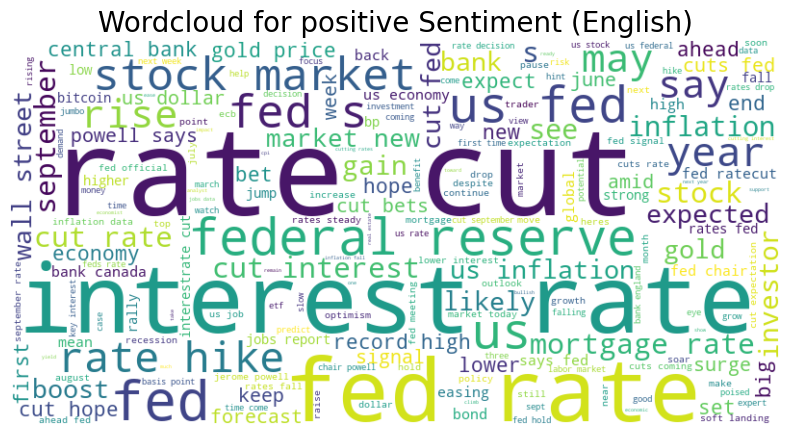

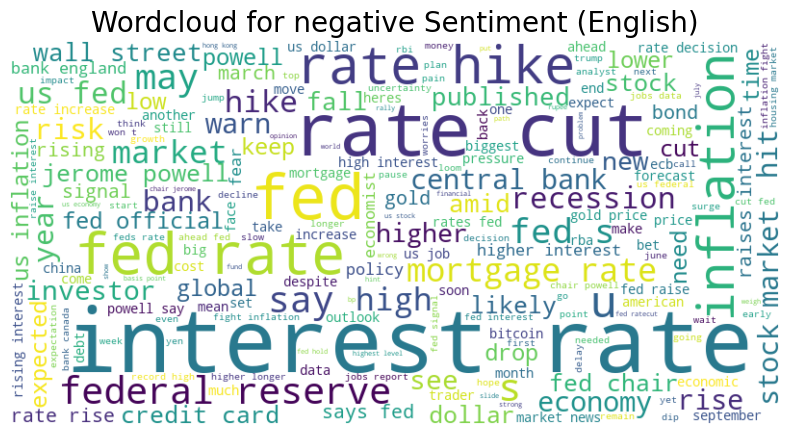

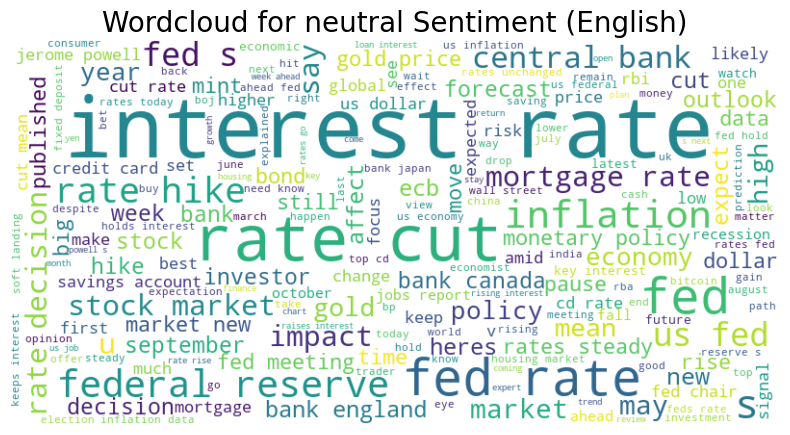

In [11]:
# Fungsi untuk menampilkan wordcloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Filter data hanya untuk bahasa Inggris
english_data = data[data['Detected Language'] == 'en']

# Menggabungkan semua teks berdasarkan sentimen untuk bahasa Inggris
positive_text_en = ' '.join(english_data[english_data['sentiment'] == 'positive']['stopword'])
negative_text_en = ' '.join(english_data[english_data['sentiment'] == 'negative']['stopword'])
neutral_text_en = ' '.join(english_data[english_data['sentiment'] == 'neutral']['stopword'])

# Membuat wordcloud untuk setiap kategori sentimen dalam bahasa Inggris
plot_wordcloud(positive_text_en, 'Wordcloud for positive Sentiment (English)')
plot_wordcloud(negative_text_en, 'Wordcloud for negative Sentiment (English)')
plot_wordcloud(neutral_text_en, 'Wordcloud for neutral Sentiment (English)')

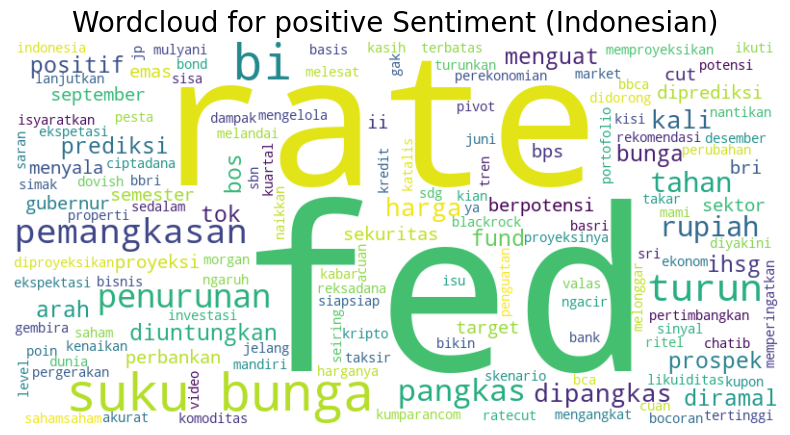

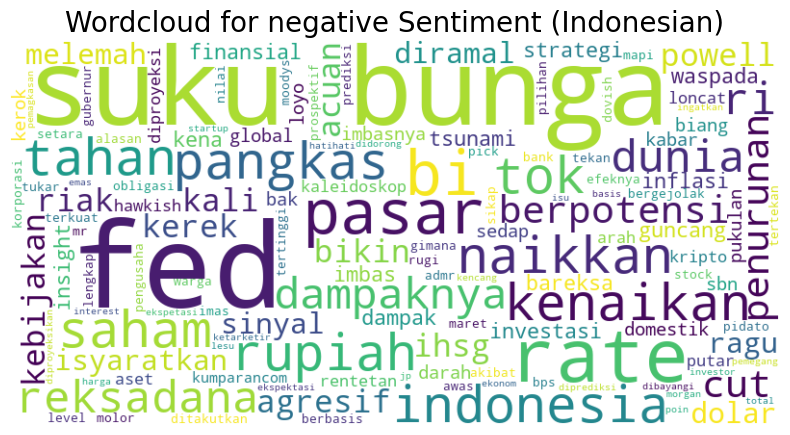

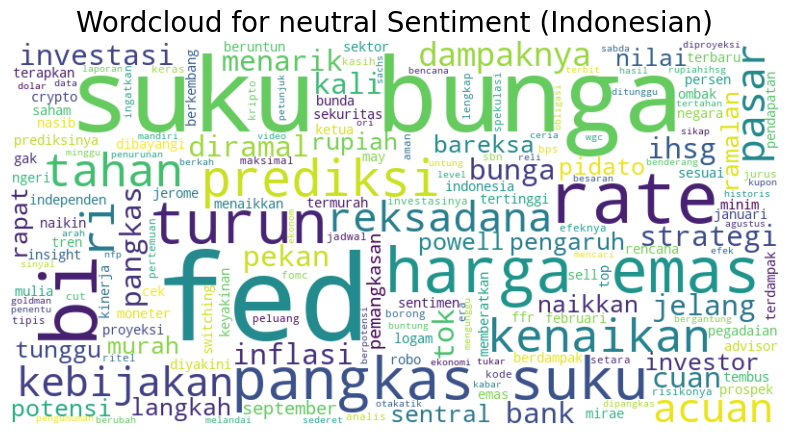

In [12]:
# Fungsi untuk menampilkan wordcloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Filter data hanya untuk bahasa Inggris
indonesian_data = data[data['Detected Language'] == 'id']

# Menggabungkan semua teks berdasarkan sentimen untuk bahasa Inggris
positive_text_en = ' '.join(indonesian_data[indonesian_data['sentiment'] == 'positive']['stopword'])
negative_text_en = ' '.join(indonesian_data[indonesian_data['sentiment'] == 'negative']['stopword'])
neutral_text_en = ' '.join(indonesian_data[indonesian_data['sentiment'] == 'neutral']['stopword'])

# Membuat wordcloud untuk setiap kategori sentimen dalam bahasa Inggris
plot_wordcloud(positive_text_en, 'Wordcloud for positive Sentiment (Indonesian)')
plot_wordcloud(negative_text_en, 'Wordcloud for negative Sentiment (Indonesian)')
plot_wordcloud(neutral_text_en, 'Wordcloud for neutral Sentiment (Indonesian)')

In [13]:
# Fungsi untuk mendapatkan unigrams yang paling sering muncul
def get_top_n_words(text_series, n):
    words = ' '.join(text_series).split()
    top_n = Counter(words).most_common(n)
    return top_n

# Mengambil top 20 unigrams untuk masing-masing sentimen
pos_unigrams = get_top_n_words(data[data['sentiment'] == 'positive']['stopword'], 20)
neg_unigrams = get_top_n_words(data[data['sentiment'] == 'negative']['stopword'], 20)
neutral_unigrams = get_top_n_words(data[data['sentiment'] == 'neutral']['stopword'], 20)

# Dataframe untuk unigrams Positif
df1 = pd.DataFrame(pos_unigrams, columns=['Text', 'count'])

# Dataframe untuk unigrams Negatif
df2 = pd.DataFrame(neg_unigrams, columns=['Text', 'count'])

# Dataframe untuk unigrams Netral
df3 = pd.DataFrame(neutral_unigrams, columns=['Text', 'count'])

# Plot unigrams untuk sentimen Positif
fig1 = px.bar(df1, x='count', y='Text', orientation='h',
              title='Top 20 Unigrams in positive Text', 
              labels={'count': 'Count', 'Text': 'Unigram'}, color='Text')
fig1.show()

# Plot unigrams untuk sentimen Negatif
fig2 = px.bar(df2, x='count', y='Text', orientation='h',
              title='Top 20 Unigrams in negative Text', 
              labels={'count': 'Count', 'Text': 'Unigram'}, color='Text')
fig2.show()

# Plot unigrams untuk sentimen Netral
fig3 = px.bar(df3, x='count', y='Text', orientation='h',
              title='Top 20 Unigrams in neutral Text', 
              labels={'count': 'Count', 'Text': 'Unigram'}, color='Text')
fig3.show()

In [14]:
# Fungsi untuk mendapatkan top n bigram
def get_top_n_gram(corpus, ngram_range, n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Mengambil top 20 bigram untuk masing-masing sentimen
pos_bigrams = get_top_n_gram(data[data['sentiment'] == 'positive']['stopword'], (2,2), 20)
neg_bigrams = get_top_n_gram(data[data['sentiment'] == 'negative']['stopword'], (2,2), 20)
neutral_bigrams = get_top_n_gram(data[data['sentiment'] == 'neutral']['stopword'], (2,2), 20)

# Dataframe untuk bigram Positif
df1 = pd.DataFrame(pos_bigrams, columns=['Text', 'count'])

# Dataframe untuk bigram Negatif
df2 = pd.DataFrame(neg_bigrams, columns=['Text', 'count'])

# Dataframe untuk bigram Netral
df3 = pd.DataFrame(neutral_bigrams, columns=['Text', 'count'])

# Plot bigrams untuk sentimen Positif
fig1 = px.bar(df1, x='count', y='Text', orientation='h',
              title='Top 20 Bigrams in positive Text',
              labels={'count': 'Count', 'Text': 'Bigram'}, color='Text')
fig1.show()

# Plot bigrams untuk sentimen Negatif
fig2 = px.bar(df2, x='count', y='Text', orientation='h',
              title='Top 20 Bigrams in negative Text',
              labels={'count': 'Count', 'Text': 'Bigram'}, color='Text')
fig2.show()

# Plot bigrams untuk sentimen Netral
fig3 = px.bar(df3, x='count', y='Text', orientation='h',
              title='Top 20 Bigrams in neutral Text',
              labels={'count': 'Count', 'Text': 'Bigram'}, color='Text')
fig3.show()

In [15]:
# Mengambil top 20 trigrams untuk masing-masing sentimen
pos_trigrams = get_top_n_gram(data[data['sentiment'] == 'positive']['stopword'], (3,3), 20)
neg_trigrams = get_top_n_gram(data[data['sentiment'] == 'negative']['stopword'], (3,3), 20)
neutral_trigrams = get_top_n_gram(data[data['sentiment'] == 'neutral']['stopword'], (3,3), 20)

# Dataframe untuk trigram Positif
df1 = pd.DataFrame(pos_trigrams, columns=['Text', 'count'])

# Dataframe untuk trigram Negatif
df2 = pd.DataFrame(neg_trigrams, columns=['Text', 'count'])

# Dataframe untuk trigram Netral
df3 = pd.DataFrame(neutral_trigrams, columns=['Text', 'count'])

# Plot trigrams untuk sentimen Positif
fig1 = px.bar(df1, x='count', y='Text', orientation='h',
              title='Top 20 Trigrams in positive Text',
              labels={'count': 'Count', 'Text': 'Trigram'}, color='Text')
fig1.show()

# Plot trigrams untuk sentimen Negatif
fig2 = px.bar(df2, x='count', y='Text', orientation='h',
              title='Top 20 Trigrams in negative Text',
              labels={'count': 'Count', 'Text': 'Trigram'}, color='Text')
fig2.show()

# Plot trigrams untuk sentimen Netral
fig3 = px.bar(df3, x='count', y='Text', orientation='h',
              title='Top 20 Trigrams in neutral Text',
              labels={'count': 'Count', 'Text': 'Trigram'}, color='Text')
fig3.show()

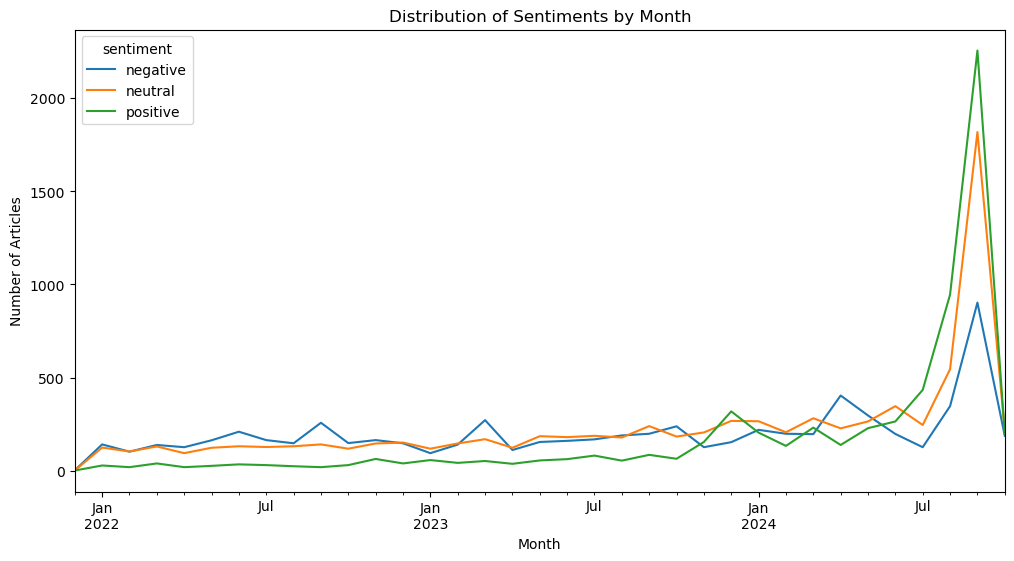

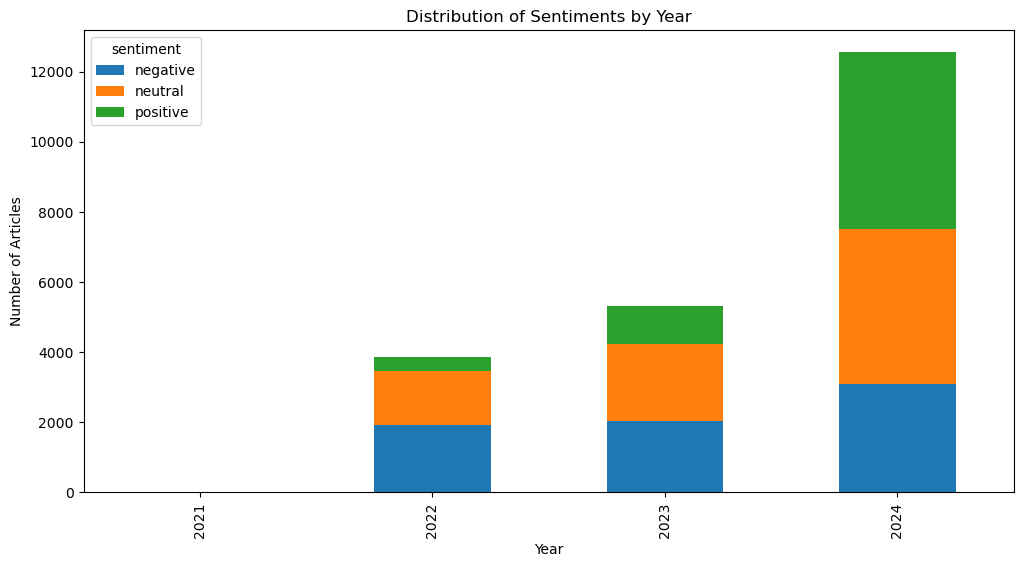

In [16]:
# Tambahkan kolom untuk periode (misalnya, bulan dan tahun)
data['Month'] = data['Waktu Terbit'].dt.to_period('M')  # Format: YYYY-MM
data['Year'] = data['Waktu Terbit'].dt.to_period('Y')   # Format: YYYY

# Mengelompokkan berdasarkan Sentimen dan Bulan
grouped_by_month = data.groupby(['Month', 'sentiment']).size().unstack().fillna(0)

# Mengelompokkan berdasarkan Sentimen dan Tahun
grouped_by_year = data.groupby(['Year', 'sentiment']).size().unstack().fillna(0)

# Visualisasi distribusi berita berdasarkan sentimen dan waktu bulanan
grouped_by_month.plot(kind='line', figsize=(12,6))
plt.title('Distribution of Sentiments by Month')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.show()

# Visualisasi distribusi berita berdasarkan sentimen dan waktu tahunan
grouped_by_year.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Distribution of Sentiments by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.show()

In [17]:
# Pastikan kolom 'Waktu Terbit' dalam format datetime, dengan opsi errors='coerce'
data['Waktu Terbit'] = pd.to_datetime(data['Waktu Terbit'], format='%d %b %Y', errors='coerce')

# Menghapus baris yang memiliki 'NaT' (tanggal tidak valid)
data = data.dropna(subset=['Waktu Terbit'])

# Tambahkan kolom untuk periode (misalnya, bulan dan tahun)
data['Month'] = data['Waktu Terbit'].dt.to_period('M')  # Format: YYYY-MM
data['Year'] = data['Waktu Terbit'].dt.to_period('Y')   # Format: YYYY

# Mengelompokkan berdasarkan Sentimen dan Bulan (Month)
grouped_by_month = data.groupby(['Month', 'sentiment']).size().unstack().fillna(0)

# Mengelompokkan berdasarkan Sentimen dan Tahun (Year)
grouped_by_year = data.groupby(['Year', 'sentiment']).size().unstack().fillna(0)

grouped_by_month

sentiment,negative,neutral,positive
Month,,,
2021-12,4,3,3
2022-01,143,126,30
2022-02,104,105,21
2022-03,140,132,41
2022-04,128,96,21
2022-05,165,125,28
2022-06,211,133,36
2022-07,166,129,32
2022-08,149,133,26


In [18]:
grouped_by_year

sentiment,negative,neutral,positive
Year,,,
2021,4,3,3
2022,1930,1543,394
2023,2026,2204,1085
2024,3089,4425,5045


In [19]:
# Tambahkan kolom untuk Hari
data['Day'] = data['Waktu Terbit'].dt.to_period('D')  # Format: YYYY-MM-DD

# Mengelompokkan berdasarkan Sentimen dan Hari (Day)
grouped_by_day = data.groupby(['Day', 'sentiment']).size().unstack().fillna(0)

# Menampilkan DataFrame yang dikelompokkan berdasarkan Hari dan Sentimen
print("Dataframe kelompok Hari dan Sentimen:")
grouped_by_day

Dataframe kelompok Hari dan Sentimen:


sentiment,negative,neutral,positive
Day,,,
2021-12-31,4.0,3.0,3.0
2022-01-01,0.0,2.0,0.0
2022-01-02,0.0,7.0,1.0
2022-01-03,3.0,6.0,0.0
2022-01-04,3.0,7.0,0.0
...,...,...,...
2024-10-03,27.0,46.0,39.0
2024-10-04,69.0,56.0,68.0
2024-10-18,1.0,0.0,0.0


In [20]:
grouped_by_day.to_csv('sentiment.csv')

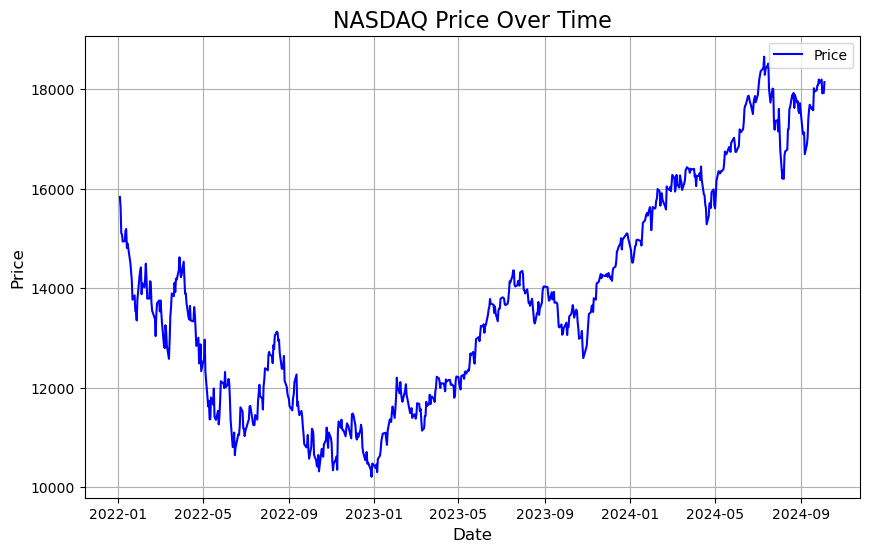

In [21]:
# Memuat data dari CSV
file_path = 'variabel lain/NASDAQ Composite Historical Data.csv'
data = pd.read_csv(file_path)

# Membersihkan kolom 'Price', 'Open', 'High', 'Low', dan 'Vol.' dari pemisah ribuan dan mengonversinya menjadi angka
data['Price'] = data['Price'].str.replace(',', '').astype(float)
data['Open'] = data['Open'].str.replace(',', '').astype(float)
data['High'] = data['High'].str.replace(',', '').astype(float)
data['Low'] = data['Low'].str.replace(',', '').astype(float)

# Konversi kolom 'Date' menjadi format datetime
data['Date'] = pd.to_datetime(data['Date'])

# Plotting harga 'Price'
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Price'], label='Price', color='blue')

# Menambahkan judul dan label sumbu
plt.title('NASDAQ Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True)

# Menampilkan grafik
plt.legend()
plt.show()

In [22]:
# Load NASDAQ data
nasdaq_data = pd.read_csv('variabel lain/NASDAQ Composite Historical Data.csv')
nasdaq_data['Date'] = pd.to_datetime(nasdaq_data['Date'])
nasdaq_data['Price'] = nasdaq_data['Price'].str.replace(',', '').astype(float)

# Load Fed Funds Rate data
fedfundrate = pd.read_csv('variabel lain/HistoricalData_1728558010085.csv')
fedfundrate['Date'] = pd.to_datetime(fedfundrate['Date'])
fedfundrate['Close/Last'] = pd.to_numeric(fedfundrate['Close/Last'], errors='coerce')  # Convert Close/Last to numeric

# Load Dollar index data
dxy = pd.read_csv('variabel lain/US Dollar Index Futures Historical Data.csv')
dxy['Date'] = pd.to_datetime(dxy['Date'])

# Check if 'Price' column is string or numeric
if dxy['Price'].dtype == 'object':
    # If it is a string, remove commas and convert to numeric
    dxy['Price'] = pd.to_numeric(dxy['Price'].str.replace(',', ''), errors='coerce')
else:
    # If already numeric, ensure it is in float format
    dxy['Price'] = dxy['Price'].astype(float)

# Rename 'Price' column for DXY
dxy.rename(columns={'Price': 'DXY Price'}, inplace=True)

# Merge NASDAQ data with Fed Funds Rate and Dollar index data based on the date
merged_data = pd.merge(nasdaq_data, fedfundrate[['Date', 'Close/Last']], on='Date', how='inner')
merged_data = pd.merge(merged_data, dxy[['Date', 'DXY Price']], on='Date', how='inner')
merged_data.rename(columns={'Close/Last': 'Fed Funds Rate'}, inplace=True)

# Create figure
fig = go.Figure()

# Add NASDAQ price line to the first y-axis
fig.add_trace(go.Scatter(x=merged_data['Date'], y=merged_data['Price'], mode='lines', name='NASDAQ Price', line=dict(color='blue')))

# Add Fed Funds Rate line to the second y-axis
fig.add_trace(go.Scatter(x=merged_data['Date'], y=merged_data['Fed Funds Rate'], mode='lines', name='Fed Funds Rate', line=dict(color='orange'), yaxis='y2'))

# Load FOMC data
fomc_data = pd.read_csv('variabel lain/FOMC Federal Funds Rate History.csv')
fomc_data['Date'] = pd.to_datetime(fomc_data['Date'], format='%d-%b-%y')

# Define a color palette
colors = px.colors.qualitative.Plotly  # You can use any color palette from Plotly

# Add FOMC meeting dates as colored dots
for idx, fomc_date in enumerate(fomc_data['Date']):
    price_on_fomc_date = merged_data.loc[merged_data['Date'] == fomc_date, 'Price'].values
    if len(price_on_fomc_date) > 0:
        fig.add_trace(go.Scatter(
            x=[fomc_date], 
            y=price_on_fomc_date, 
            mode='markers',  # Just markers without text
            marker=dict(color=colors[idx % len(colors)], size=10),  # Cycle through colors
            name=f'FOMC Date: {fomc_date.strftime("%Y-%m-%d")}',  # Add to legend with FOMC date
            legendgroup='FOMC',  # Grouping for better legend management
            showlegend=True  # Show in legend
        ))

# Update layout with secondary y-axis and larger size
fig.update_layout(
    title='NASDAQ Price and Fed Funds Rate',
    xaxis_title='Date',
    yaxis_title='NASDAQ Price',
    yaxis2=dict(title='Fed Funds Rate', overlaying='y', side='right'),  # Right y-axis
    hovermode='x unified',
    width=1800,  # Set the width of the figure
    height=900  # Set the height of the figure
)

# Show the figure
fig.show()


In [23]:
# Create figure
fig = go.Figure()

# Add NASDAQ price line to the first y-axis
fig.add_trace(go.Scatter(x=merged_data['Date'], y=merged_data['Price'], mode='lines', name='NASDAQ Price', line=dict(color='blue')))

# Add DXY price line to the second y-axis
fig.add_trace(go.Scatter(x=merged_data['Date'], y=merged_data['DXY Price'], mode='lines', name='DXY Price', line=dict(color='green'), yaxis='y2'))

# Define a color palette
colors = px.colors.qualitative.Plotly  # You can use any color palette from Plotly

# Add FOMC meeting dates as colored dots
for idx, fomc_date in enumerate(fomc_data['Date']):
    price_on_fomc_date = merged_data.loc[merged_data['Date'] == fomc_date, 'Price'].values
    if len(price_on_fomc_date) > 0:
        fig.add_trace(go.Scatter(
            x=[fomc_date], 
            y=price_on_fomc_date, 
            mode='markers',  # Just markers without text
            marker=dict(color=colors[idx % len(colors)], size=10),  # Cycle through colors
            name=f'FOMC Date: {fomc_date.strftime("%Y-%m-%d")}',  # Add to legend with FOMC date
            legendgroup='FOMC',  # Grouping for better legend management
            showlegend=True  # Show in legend
        ))

# Update layout with secondary y-axis and larger size
fig.update_layout(
    title='NASDAQ Price and DXY Price',
    xaxis_title='Date',
    yaxis_title='NASDAQ Price',
    yaxis2=dict(title='DXY Price', overlaying='y', side='right'),  # Right y-axis
    hovermode='x unified',
    width=1800,  # Set the width of the figure
    height=900  # Set the height of the figure
)

# Show the figure
fig.show()

In [24]:
merged_data

,Date,Price,Open,High,Low,Vol.,Change %,Fed Funds Rate,DXY Price
0,2022-01-03,15832.80,"15,732.50","15,832.80","15,644.09",871.65M,1.20%,0.08,96.211
1,2022-01-04,15622.72,"15,852.14","15,852.14","15,512.41",970.70M,-1.33%,0.08,96.274
2,2022-01-05,15100.17,"15,547.16","15,586.30","15,095.18",1.01B,-3.34%,0.08,96.182
3,2022-01-06,15080.86,"15,024.15","15,198.45","14,914.87",951.12M,-0.13%,0.08,96.326
4,2022-01-07,14935.90,"15,095.72","15,171.02","14,877.63",852.53M,-0.96%,0.08,95.722
...,...,...,...,...,...,...,...,...,...
688,2024-09-30,18189.17,"18,069.83","18,198.16","17,997.56",1.20B,0.38%,4.83,100.521
689,2024-10-01,17910.36,"18,154.94","18,162.72","17,779.77",1.11B,-1.53%,4.83,100.931
690,2024-10-02,17925.12,"17,867.12","17,978.57","17,767.79",985.44M,0.08%,4.83,101.425
691,2024-10-03,17918.48,"17,859.49","18,011.25","17,826.42",908.71M,-0.04%,4.83,101.750


In [25]:
sentiment=pd.read_csv('sentiment.csv')
sentiment

,Day,negative,neutral,positive
0,2021-12-31,4.0,3.0,3.0
1,2022-01-01,0.0,2.0,0.0
2,2022-01-02,0.0,7.0,1.0
3,2022-01-03,3.0,6.0,0.0
4,2022-01-04,3.0,7.0,0.0
...,...,...,...,...
1000,2024-10-03,27.0,46.0,39.0
1001,2024-10-04,69.0,56.0,68.0
1002,2024-10-18,1.0,0.0,0.0
1003,2024-10-23,1.0,0.0,0.0


In [26]:
# Menentukan tanggal yang ada di merged_data tetapi tidak ada di sentiment
missing_in_sentiment = merged_data[~merged_data['Date'].isin(sentiment['Day'])]

# Menentukan tanggal yang ada di sentiment tetapi tidak ada di merged_data
missing_in_merged_data = sentiment[~sentiment['Day'].isin(merged_data['Date'])]

# Menampilkan hasil
print("Tanggal yang ada di merged_data tetapi tidak ada di sentiment:")
missing_in_sentiment['Date']

Tanggal yang ada di merged_data tetapi tidak ada di sentiment:


Series([], Name: Date, dtype: datetime64[ns])

In [27]:
sentiment['Day'] = pd.to_datetime(sentiment['Day'])  # Convert Day to datetime

# Merge merged_data with sentiment data based on date
final_data = pd.merge(merged_data, sentiment, left_on='Date', right_on='Day', how='inner')
# Drop the 'Day' column if not needed
final_data.drop(columns=['Open', 'High', 'Low', 'Day'], inplace=True)
# Fungsi untuk mengonversi Volume
def convert_volume(vol):
    if vol.endswith("M"):
        return float(vol[:-1]) * 10**6  # Menghilangkan 'M' dan kalikan 10^6
    elif vol.endswith("B"):
        return float(vol[:-1]) * 10**9  # Menghilangkan 'B' dan kalikan 10^9
    else:
        return float(vol)  # Jika tidak ada akhiran, tetap sebagai float

# Terapkan fungsi ke kolom 'Vol.'
final_data["Vol."] = final_data["Vol."].apply(convert_volume)
final_data['Fed Funds Rate'] = final_data['Fed Funds Rate']/100
final_data['Change %'] = final_data['Change %'].str.replace('%', '').astype(float)/100
# Display the final combined DataFrame
final_data

,Date,Price,Vol.,Change %,Fed Funds Rate,DXY Price,negative,neutral,positive
0,2022-01-03,15832.80,8.716500e+08,0.0120,0.0008,96.211,3.0,6.0,0.0
1,2022-01-04,15622.72,9.707000e+08,-0.0133,0.0008,96.274,3.0,7.0,0.0
2,2022-01-05,15100.17,1.010000e+09,-0.0334,0.0008,96.182,5.0,4.0,1.0
3,2022-01-06,15080.86,9.511200e+08,-0.0013,0.0008,96.326,5.0,4.0,1.0
4,2022-01-07,14935.90,8.525300e+08,-0.0096,0.0008,95.722,6.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...
688,2024-09-30,18189.17,1.200000e+09,0.0038,0.0483,100.521,38.0,77.0,86.0
689,2024-10-01,17910.36,1.110000e+09,-0.0153,0.0483,100.931,59.0,67.0,59.0
690,2024-10-02,17925.12,9.854400e+08,0.0008,0.0483,101.425,31.0,45.0,34.0
691,2024-10-03,17918.48,9.087100e+08,-0.0004,0.0483,101.750,27.0,46.0,39.0


In [29]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            693 non-null    datetime64[ns]
 1   Price           693 non-null    float64       
 2   Vol.            693 non-null    float64       
 3   Change %        693 non-null    float64       
 4   Fed Funds Rate  693 non-null    float64       
 5   DXY Price       693 non-null    float64       
 6   negative        693 non-null    float64       
 7   neutral         693 non-null    float64       
 8   positive        693 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 48.9 KB


In [30]:
# Find the row with the highest increase
max_increase_day = final_data.loc[final_data['Change %'].idxmax()]

# Find the row with the highest decrease
max_decrease_day = final_data.loc[final_data['Change %'].idxmin()]

print("Kenaikan tertinggi terjadi pada:")
print(max_increase_day[['Date', 'Change %']])

print("\nPenurunan terdalam terjadi pada:")
print(max_decrease_day[['Date', 'Change %']])

Kenaikan tertinggi terjadi pada:
Date        2022-11-10 00:00:00
Change %                 0.0735
Name: 216, dtype: object

Penurunan terdalam terjadi pada:
Date        2022-09-13 00:00:00
Change %                -0.0516
Name: 174, dtype: object


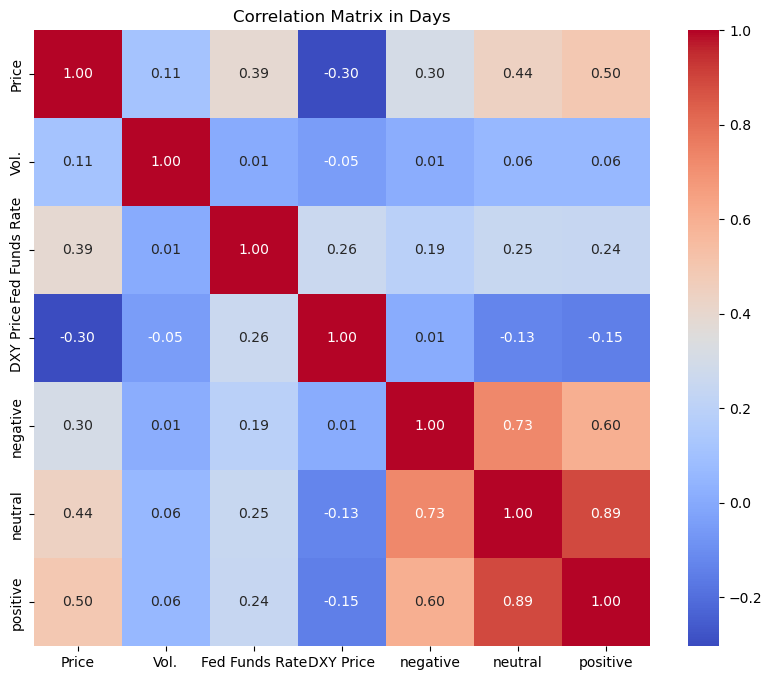

In [31]:
# Menghapus kolom 'Date'
df_no_date = final_data.drop(columns=['Date','Change %'])

# Menghitung korelasi tanpa kolom 'Date'
correlation_matrix_no_date = df_no_date.corr()

# Membuat heatmap menggunakan seaborn tanpa kolom 'Date'
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_date, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f')
plt.title("Correlation Matrix in Days")
plt.show()

In [32]:
grouped_month = final_data.groupby(final_data['Date'].dt.to_period('M')).agg({
    'Price': 'mean',
    'Fed Funds Rate': 'mean',
    'DXY Price': 'mean',
    'negative': 'mean',
    'neutral': 'mean',
    'positive': 'mean',
    'Vol.': 'mean'
}).reset_index()

grouped_month

,Date,Price,Fed Funds Rate,DXY Price,negative,neutral,positive,Vol.
0,2022-01,14531.377500,0.000800,95.951250,6.100000,4.800000,1.100000,1.032440e+09
1,2022-02,13898.727895,0.000800,95.990421,4.157895,4.631579,0.947368,9.949242e+08
2,2022-03,13623.263043,0.001996,98.478261,5.565217,4.826087,1.695652,1.172382e+09
3,2022-04,13394.163000,0.003300,100.712900,5.350000,3.950000,0.700000,9.515935e+08
4,2022-05,11829.729524,0.007586,103.196905,7.047619,4.904762,1.047619,1.109483e+09
5,2022-06,11418.919048,0.011871,103.711048,8.857143,5.476190,1.428571,1.273445e+09
6,2022-07,11622.631000,0.016545,106.881300,6.400000,5.200000,1.500000,9.088815e+08
7,2022-08,12570.259565,0.023300,107.060478,5.347826,4.956522,1.043478,9.427622e+08
8,2022-09,11402.849524,0.025800,110.682619,10.904762,5.523810,0.857143,1.049228e+09
9,2022-10,10801.494762,0.030800,111.844810,6.095238,4.190476,1.285714,9.484086e+08


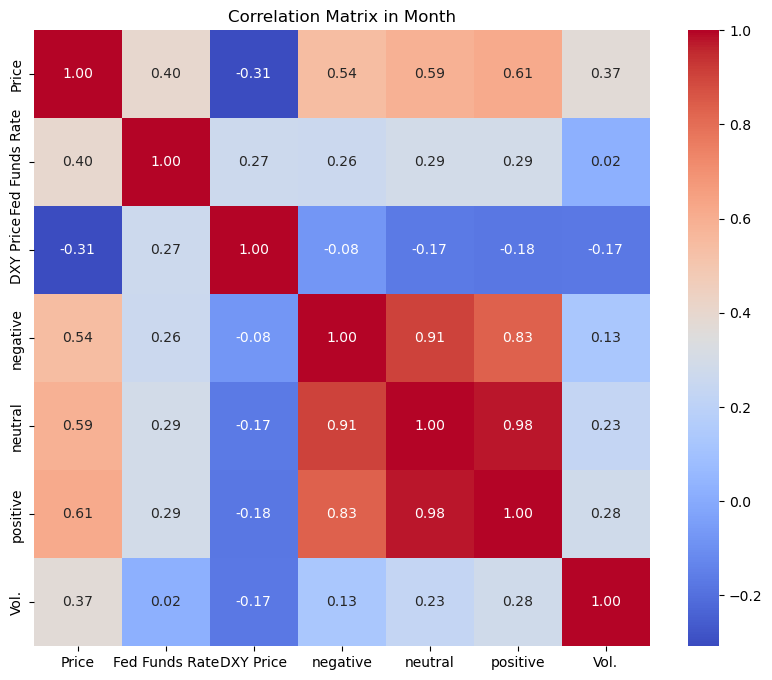

In [33]:
# Menghapus kolom 'Date'
df_no_date = grouped_month.drop(columns=['Date'])

# Menghitung korelasi tanpa kolom 'Date'
correlation_matrix_no_date = df_no_date.corr()

# Membuat heatmap menggunakan seaborn tanpa kolom 'Date'
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_date, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f')
plt.title("Correlation Matrix in Month")
plt.show()

In [34]:
grouped_year = final_data.groupby(final_data['Date'].dt.to_period('Y')).agg({
    'Price': 'mean',
    'Fed Funds Rate': 'mean',
    'DXY Price': 'mean',
    'negative': 'mean',
    'neutral': 'mean',
    'positive': 'mean',
    'Vol.': 'mean'
}).reset_index()

grouped_year

,Date,Price,Fed Funds Rate,DXY Price,negative,neutral,positive,Vol.
0,2022,12231.348327,0.016955,103.987147,6.605578,5.103586,1.334661,1.032542e+09
1,2023,12970.275520,0.050281,103.260016,7.252000,7.756000,3.868000,1.004982e+09
2,2024,16683.981146,0.052987,103.581010,14.526042,20.567708,23.510417,1.117153e+09


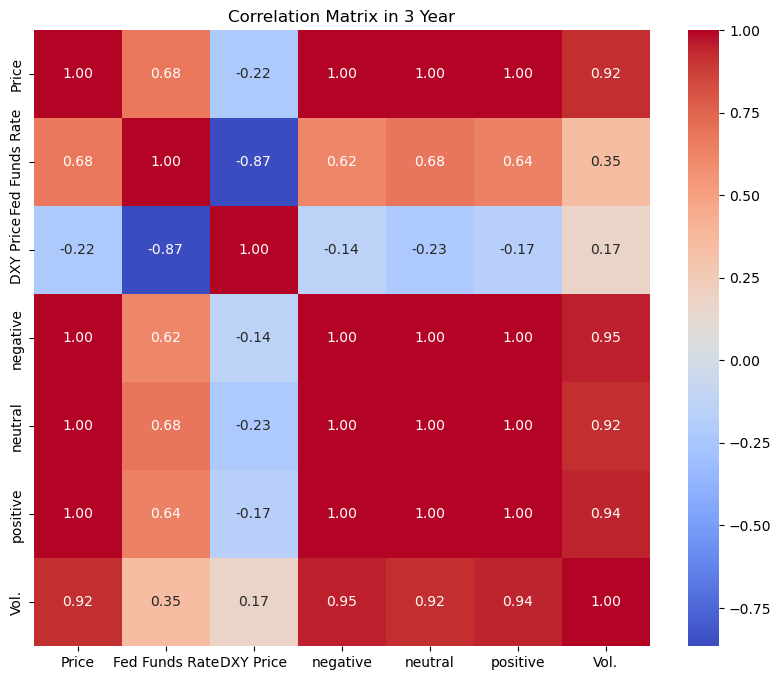

In [35]:
# Menghapus kolom 'Date'
df_no_date = grouped_year.drop(columns=['Date'])

# Menghitung korelasi tanpa kolom 'Date'
correlation_matrix_no_date = df_no_date.corr()

# Membuat heatmap menggunakan seaborn tanpa kolom 'Date'
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_date, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f')
plt.title("Correlation Matrix in 3 Year")
plt.show()

In [36]:
# Tentukan indeks untuk split 90:10
split_index = int(0.9 * len(final_data))

# Split data menjadi training dan testing set
train_data = final_data.iloc[:split_index]
test_data = final_data.iloc[split_index:]

In [37]:
train_data.iloc[:20]

,Date,Price,Vol.,Change %,Fed Funds Rate,DXY Price,negative,neutral,positive
0,2022-01-03,15832.80,8.716500e+08,0.0120,0.0008,96.211,3.0,6.0,0.0
1,2022-01-04,15622.72,9.707000e+08,-0.0133,0.0008,96.274,3.0,7.0,0.0
2,2022-01-05,15100.17,1.010000e+09,-0.0334,0.0008,96.182,5.0,4.0,1.0
3,2022-01-06,15080.86,9.511200e+08,-0.0013,0.0008,96.326,5.0,4.0,1.0
4,2022-01-07,14935.90,8.525300e+08,-0.0096,0.0008,95.722,6.0,3.0,0.0
5,2022-01-10,14942.83,1.090000e+09,0.0005,0.0008,95.990,7.0,4.0,2.0
6,2022-01-11,15153.45,8.630200e+08,0.0141,0.0008,95.625,5.0,3.0,1.0
7,2022-01-12,15188.39,8.400200e+08,0.0023,0.0008,94.901,10.0,5.0,0.0
8,2022-01-13,14806.81,8.521500e+08,-0.0251,0.0008,94.775,3.0,3.0,4.0
9,2022-01-14,14893.75,8.725600e+08,0.0059,0.0008,95.161,4.0,5.0,1.0


In [38]:
test_data.iloc[:20]

,Date,Price,Vol.,Change %,Fed Funds Rate,DXY Price,negative,neutral,positive
623,2024-06-27,17858.68,1.050000e+09,0.0030,0.0533,105.571,6.0,9.0,9.0
624,2024-06-28,17732.60,3.780000e+09,-0.0071,0.0533,105.545,4.0,5.0,15.0
625,2024-07-01,17879.30,1.030000e+09,0.0083,0.0533,105.587,6.0,9.0,7.0
626,2024-07-02,18028.76,9.321200e+08,0.0084,0.0533,105.407,9.0,14.0,8.0
627,2024-07-03,18188.30,6.920600e+08,0.0088,0.0533,105.077,8.0,6.0,14.0
628,2024-07-05,18352.76,9.638000e+08,0.0090,0.0533,104.548,7.0,3.0,14.0
629,2024-07-08,18403.74,9.847600e+08,0.0028,0.0533,104.668,6.0,7.0,15.0
630,2024-07-09,18429.29,9.148000e+08,0.0014,0.0533,104.807,8.0,12.0,23.0
631,2024-07-10,18647.45,9.713600e+08,0.0118,0.0533,104.729,10.0,20.0,22.0
632,2024-07-11,18283.41,1.230000e+09,-0.0195,0.0533,104.131,10.0,8.0,53.0


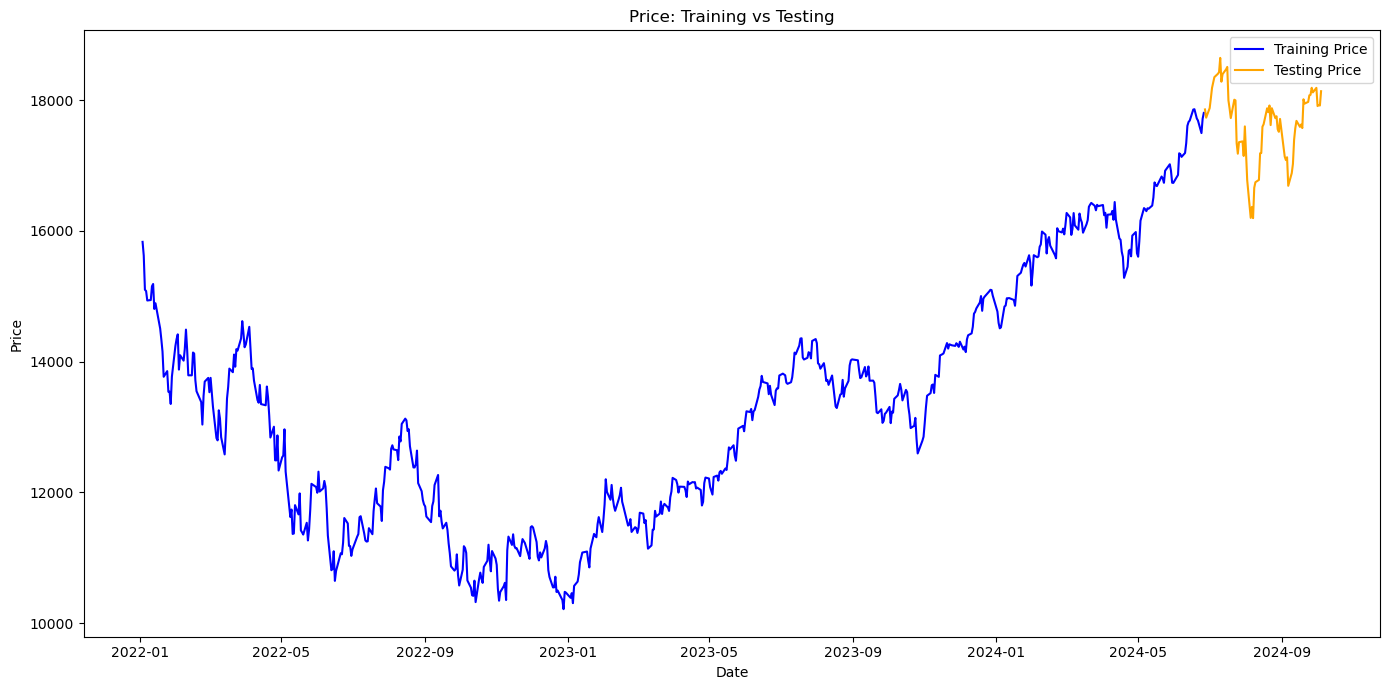

In [39]:
# Plot Price dan Fed Funds Rate untuk data train dan test
plt.figure(figsize=(14, 7))

# Plot Price
plt.plot(train_data['Date'], train_data['Price'], label='Training Price', color='blue')
plt.plot(test_data['Date'], test_data['Price'], label='Testing Price', color='orange')
plt.title('Price: Training vs Testing')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()

In [40]:
# Inisialisasi scaler
scaler_price = MinMaxScaler()
scaler_dxy = MinMaxScaler()
scaler_vol = MinMaxScaler()

# Salin data asli ke variabel baru agar tidak mengubah train_data dan test_data
scaled_train_data = train_data.copy()
scaled_test_data = test_data.copy()

# Fit dan transform 'Price' pada training set
scaled_train_data['Price'] = scaler_price.fit_transform(train_data[['Price']])

# Transform 'Price' pada test set
scaled_test_data['Price'] = scaler_price.transform(test_data[['Price']])

# Fit dan transform 'DXY Price' pada training set
scaled_train_data['DXY Price'] = scaler_dxy.fit_transform(train_data[['DXY Price']])

# Transform 'DXY Price' pada test set
scaled_test_data['DXY Price'] = scaler_dxy.transform(test_data[['DXY Price']])

# Fit dan transform 'Vol.' pada training set
scaled_train_data['Vol.'] = scaler_vol.fit_transform(train_data[['Vol.']])

# Transform 'Vol.' pada test set
scaled_test_data['Vol.'] = scaler_vol.transform(test_data[['Vol.']])

# Sekarang, scaled_train_data dan scaled_test_data adalah variabel baru yang berisi hasil scaling


In [41]:
scaled_train_data.iloc[:20]

,Date,Price,Vol.,Change %,Fed Funds Rate,DXY Price,negative,neutral,positive
0,2022-01-03,0.734678,0.125731,0.0120,0.0008,0.074512,3.0,6.0,0.0
1,2022-01-04,0.707213,0.150917,-0.0133,0.0008,0.077781,3.0,7.0,0.0
2,2022-01-05,0.638896,0.160910,-0.0334,0.0008,0.073007,5.0,4.0,1.0
3,2022-01-06,0.636372,0.145938,-0.0013,0.0008,0.080479,5.0,4.0,1.0
4,2022-01-07,0.617420,0.120870,-0.0096,0.0008,0.049139,6.0,3.0,0.0
5,2022-01-10,0.618326,0.181251,0.0005,0.0008,0.063045,7.0,4.0,2.0
6,2022-01-11,0.645862,0.123537,0.0141,0.0008,0.044105,5.0,3.0,1.0
7,2022-01-12,0.650430,0.117689,0.0023,0.0008,0.006538,10.0,5.0,0.0
8,2022-01-13,0.600543,0.120773,-0.0251,0.0008,0.000000,3.0,3.0,4.0
9,2022-01-14,0.611910,0.125963,0.0059,0.0008,0.020029,4.0,5.0,1.0


In [42]:
scaled_test_data.iloc[:20]

,Date,Price,Vol.,Change %,Fed Funds Rate,DXY Price,negative,neutral,positive
623,2024-06-27,0.999536,0.171080,0.0030,0.0533,0.560191,6.0,9.0,9.0
624,2024-06-28,0.983053,0.865237,-0.0071,0.0533,0.558842,4.0,5.0,15.0
625,2024-07-01,1.002232,0.165995,0.0083,0.0533,0.561021,6.0,9.0,7.0
626,2024-07-02,1.021772,0.141107,0.0084,0.0533,0.551681,9.0,14.0,8.0
627,2024-07-03,1.042629,0.080067,0.0088,0.0533,0.534558,8.0,6.0,14.0
628,2024-07-05,1.064130,0.149162,0.0090,0.0533,0.507109,7.0,3.0,14.0
629,2024-07-08,1.070795,0.154492,0.0028,0.0533,0.513335,6.0,7.0,15.0
630,2024-07-09,1.074136,0.136703,0.0014,0.0533,0.520548,8.0,12.0,23.0
631,2024-07-10,1.102657,0.151085,0.0118,0.0533,0.516501,10.0,20.0,22.0
632,2024-07-11,1.055064,0.216849,-0.0195,0.0533,0.485471,10.0,8.0,53.0


In [84]:
def create_dataset_multifeature(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back + 1):
        # Mengambil window sebesar look_back hanya untuk kolom X
        X.append(dataset[i:(i + look_back), :-1])  # Fitur: Semua kolom kecuali terakhir (Change %)
        Y.append(dataset[i + look_back - 1, -1])  # Target: Change % pada indeks terakhir dari window
    return np.array(X), np.array(Y)

# Menggabungkan fitur yang relevan menjadi satu array
# Fitur X: 'DXY Price', 'Fed Funds Rate', 'negative', 'neutral', 'positive'
# Target Y: 'Price'
train = scaled_train_data[['DXY Price', 'Fed Funds Rate', 'negative', 'neutral', 'positive', 'Vol.','Price']].values
test = scaled_test_data[['DXY Price', 'Fed Funds Rate', 'negative', 'neutral', 'positive', 'Vol.','Price']].values

# Membuat dataset dengan look_back
look_back = 10
X_train, y_train = create_dataset_multifeature(train, look_back)
X_test, y_test = create_dataset_multifeature(test, look_back)

# Reshape input menjadi [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [85]:
print(X_train.shape)
print(X_test.shape)

(614, 10, 6)
(61, 10, 6)


In [86]:
print(y_train.shape)
print(y_test.shape)

(614,)
(61,)


In [87]:
X_train

array([[[7.45122457e-02, 8.00000000e-04, 3.00000000e+00, 6.00000000e+00,
         0.00000000e+00, 1.25731344e-01],
        [7.77812370e-02, 8.00000000e-04, 3.00000000e+00, 7.00000000e+00,
         0.00000000e+00, 1.50916770e-01],
        [7.30074720e-02, 8.00000000e-04, 5.00000000e+00, 4.00000000e+00,
         1.00000000e+00, 1.60909574e-01],
        ...,
        [6.53798257e-03, 8.00000000e-04, 1.00000000e+01, 5.00000000e+00,
         0.00000000e+00, 1.17688789e-01],
        [0.00000000e+00, 8.00000000e-04, 3.00000000e+00, 3.00000000e+00,
         4.00000000e+00, 1.20773082e-01],
        [2.00290577e-02, 8.00000000e-04, 4.00000000e+00, 5.00000000e+00,
         1.00000000e+00, 1.25962729e-01]],

       [[7.77812370e-02, 8.00000000e-04, 3.00000000e+00, 7.00000000e+00,
         0.00000000e+00, 1.50916770e-01],
        [7.30074720e-02, 8.00000000e-04, 5.00000000e+00, 4.00000000e+00,
         1.00000000e+00, 1.60909574e-01],
        [8.04794521e-02, 8.00000000e-04, 5.00000000e+00, 4.000000

In [88]:
y_train

array([0.61190962, 0.56133399, 0.53954666, 0.51519949, 0.46485265,
       0.47612349, 0.4348328 , 0.43520148, 0.41044772, 0.46506836,
       0.52642458, 0.54029839, 0.54965263, 0.47922065, 0.50787691,
       0.49711202, 0.52048519, 0.55917291, 0.5193334 , 0.46775893,
       0.46772886, 0.51333518, 0.51128653, 0.45802817, 0.43597936,
       0.41420511, 0.36922763, 0.42624076, 0.45513888, 0.46256213,
       0.43393856, 0.46264319, 0.434655  , 0.40530453, 0.3422265 ,
       0.3375971 , 0.39773616, 0.38131689, 0.34390648, 0.30957623,
       0.35760903, 0.42139957, 0.44470083, 0.48118432, 0.4739441 ,
       0.50929018, 0.48494432, 0.52014397, 0.51719715, 0.54146195,
       0.57607329, 0.55288445, 0.52389351, 0.52925111, 0.56468739,
       0.52175596, 0.48052802, 0.48163667, 0.45728036, 0.41818474,
       0.41290427, 0.44846737, 0.41022547, 0.40777807, 0.44533883,
       0.42355934, 0.38715953, 0.34331554, 0.36496037, 0.29774714,
       0.2975105 , 0.34753051, 0.27733908, 0.30366691, 0.30729

In [89]:
X_test

array([[[5.60190951e-01, 5.33000000e-02, 6.00000000e+00, 9.00000000e+00,
         9.00000000e+00, 1.71080367e-01],
        [5.58841843e-01, 5.33000000e-02, 4.00000000e+00, 5.00000000e+00,
         1.50000000e+01, 8.65236992e-01],
        [5.61021171e-01, 5.33000000e-02, 6.00000000e+00, 9.00000000e+00,
         7.00000000e+00, 1.65994971e-01],
        ...,
        [5.20547945e-01, 5.33000000e-02, 8.00000000e+00, 1.20000000e+01,
         2.30000000e+01, 1.36703087e-01],
        [5.16500623e-01, 5.33000000e-02, 1.00000000e+01, 2.00000000e+01,
         2.20000000e+01, 1.51084588e-01],
        [4.85471150e-01, 5.33000000e-02, 1.00000000e+01, 8.00000000e+00,
         5.30000000e+01, 2.16848936e-01]],

       [[5.58841843e-01, 5.33000000e-02, 4.00000000e+00, 5.00000000e+00,
         1.50000000e+01, 8.65236992e-01],
        [5.61021171e-01, 5.33000000e-02, 6.00000000e+00, 9.00000000e+00,
         7.00000000e+00, 1.65994971e-01],
        [5.51681196e-01, 5.33000000e-02, 9.00000000e+00, 1.400000

In [90]:
y_test

array([1.05506384, 1.07010383, 1.07979406, 1.08460127, 1.01761028,
       1.00117533, 0.98231258, 1.01900133, 1.01766519, 0.93204026,
       0.91103212, 0.93406276, 0.93567344, 0.90654784, 0.96563838,
       0.91265587, 0.85801039, 0.78269538, 0.80449971, 0.78213713,
       0.84282659, 0.85397585, 0.85859217, 0.91180216, 0.91245454,
       0.96499776, 0.9698638 , 1.00190092, 0.99407892, 1.00742064,
       0.96824658, 1.00203427, 0.98215962, 0.98595753, 0.95996831,
       0.95479112, 0.98057116, 0.90509404, 0.89829571, 0.90396447,
       0.8468546 , 0.87218752, 0.89065805, 0.93898501, 0.96175287,
       0.97669612, 0.96468792, 0.9693853 , 0.96222614, 1.01983935,
       1.01125515, 1.01464778, 1.02775417, 1.02875954, 1.0428896 ,
       1.03364649, 1.04274318, 1.00629238, 1.00822205, 1.00735396,
       1.03603375])

In [91]:
# Set learning rate
learning_rate = 0.01  # Keeping the same learning rate

# Input layer
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# First LSTM layer
x1 = LSTM(units=16, return_sequences=True)(inputs)
x1 = ReLU()(x1)

# Second LSTM layer
x2 = LSTM(units=32, return_sequences=True)(x1)
x2 = ReLU()(x2)

# Attention layer
attention = Attention()([x2, x2])

# Third LSTM layer
x3 = LSTM(units=32, return_sequences=False)(attention)
x3 = ReLU()(x3)

# Fully connected layers before output
fc = Dense(64, activation='relu')(x3)

# Output layer
outputs = Dense(1)(fc)

# Define the model with skip connections
model = Model(inputs=inputs, outputs=outputs)

# Compile model with Log-Cosh loss
model.compile(loss=logcosh, optimizer=Adam(learning_rate=learning_rate), metrics=['mse'])

# Display model summary
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 10, 6)]              0         []                            
                                                                                                  
 lstm_18 (LSTM)              (None, 10, 16)               1472      ['input_7[0][0]']             
                                                                                                  
 re_lu_18 (ReLU)             (None, 10, 16)               0         ['lstm_18[0][0]']             
                                                                                                  
 lstm_19 (LSTM)              (None, 10, 32)               6272      ['re_lu_18[0][0]']            
                                                                                            

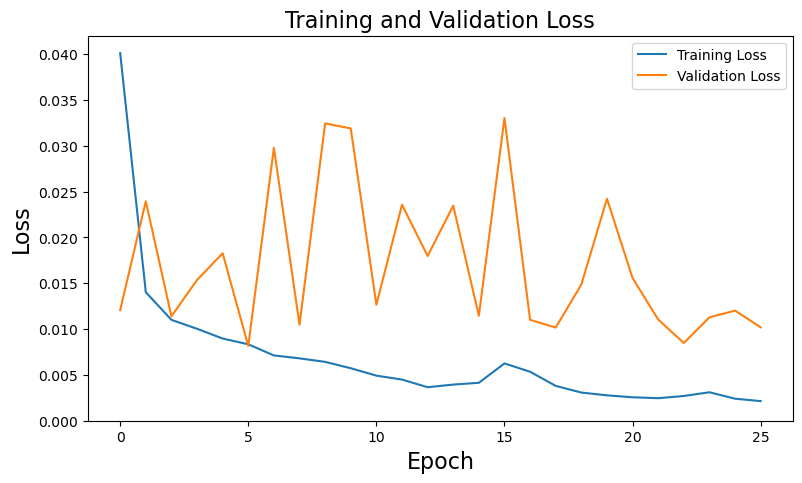

In [92]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

In [93]:
# LSTM Predictions
predictions = model.predict(X_test)

# Karena scaler di-fit pada lebih dari satu kolom, kita hanya inverse transform untuk 'Price'
predicted_price = scaler_price.inverse_transform(predictions)

# Tampilkan hasil prediksi yang sudah di-unscaling
predicted_price

2/2 [==============================] - 2s 8ms/step


array([[16224.283],
       [16311.169],
       [16443.525],
       [16653.713],
       [16831.523],
       [16819.775],
       [16858.984],
       [16743.637],
       [16477.193],
       [15836.289],
       [15992.928],
       [15958.533],
       [16086.592],
       [16151.276],
       [16020.512],
       [16104.828],
       [16460.945],
       [16793.271],
       [16865.016],
       [16938.266],
       [17065.16 ],
       [17190.9  ],
       [17125.959],
       [17036.918],
       [17200.074],
       [17272.572],
       [17071.188],
       [16440.078],
       [16064.552],
       [16093.91 ],
       [16410.867],
       [16694.375],
       [16977.791],
       [17014.72 ],
       [17269.03 ],
       [17374.299],
       [17498.398],
       [17607.654],
       [17710.36 ],
       [17842.33 ],
       [17929.865],
       [18126.66 ],
       [18210.385],
       [18204.602],
       [18205.94 ],
       [18202.547],
       [18178.182],
       [18200.602],
       [18213.943],
       [18208.736],


In [94]:
actual_change = scaler_price.inverse_transform(y_test.reshape(-1, 1))
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predicted_price - actual_change) ** 2)))
rmse

980.0872539334838

In [95]:
# Ambil tanggal terakhir dari test_data
last_date = scaled_test_data['Date'].iloc[-1]

# Buat daftar tanggal untuk 20 hari ke depan
future_dates = pd.date_range(last_date + BDay(1), periods=30, freq='B')

# Melakukan prediksi harga untuk 20 hari ke depan
future_predictions = []
input_data = X_test[-1:]  # Ambil data terakhir dari X_test untuk prediksi pertama

for _ in range(30):
    # Buat prediksi
    prediction = model.predict(input_data)
    future_predictions.append(prediction[0, 0])  # Ambil nilai prediksi pertama

    # Siapkan input untuk prediksi berikutnya
    input_data = np.append(input_data[:, 1:, :], [[np.append(input_data[0, -1, 1:], prediction)]], axis=1)

# Inverse transform untuk mendapatkan harga asli
future_predictions_scaled = scaler_price.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Buat DataFrame untuk hasil prediksi
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted change': future_predictions_scaled.flatten()
})
forecast_df

1/1 [==============================] - 0s 28ms/step


,Date,Predicted change
0,2024-10-07,18151.316406
1,2024-10-08,18119.705078
2,2024-10-09,17939.166016
3,2024-10-10,17663.792969
4,2024-10-11,17386.044922
5,2024-10-14,16714.554688
6,2024-10-15,15452.257812
7,2024-10-16,13810.303711
8,2024-10-17,11739.142578
9,2024-10-18,11101.463867


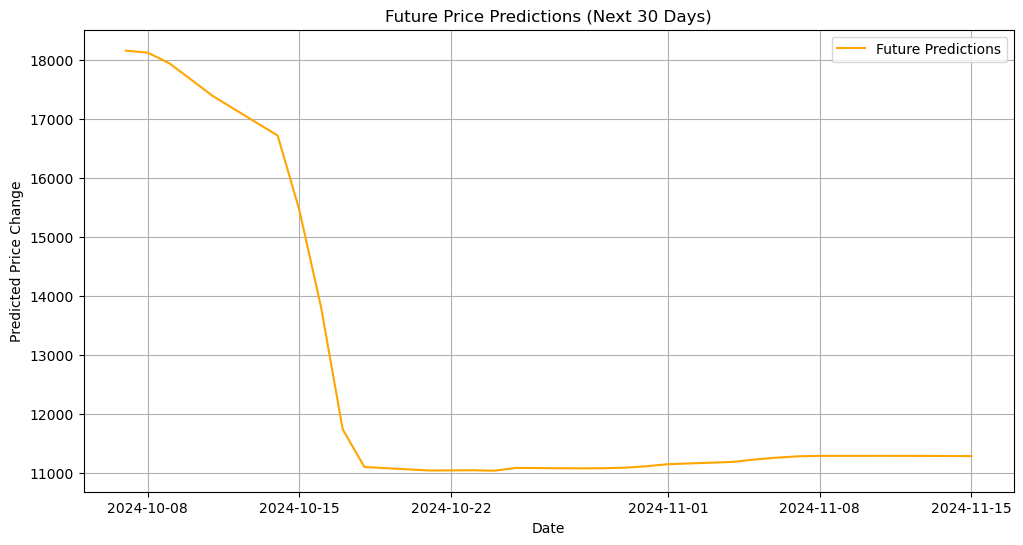

In [100]:
# Visualisasi hasil prediksi masa depan
plt.figure(figsize=(12, 6))

# Plot prediksi masa depan
plt.plot(forecast_df['Date'], forecast_df['Predicted change'], label='Future Predictions', color='orange')

# Menambahkan elemen grafik
plt.title('Future Price Predictions (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Predicted Price Change')
plt.grid(True)
plt.legend()
plt.show()

20/20 [==============================] - 0s 8ms/step


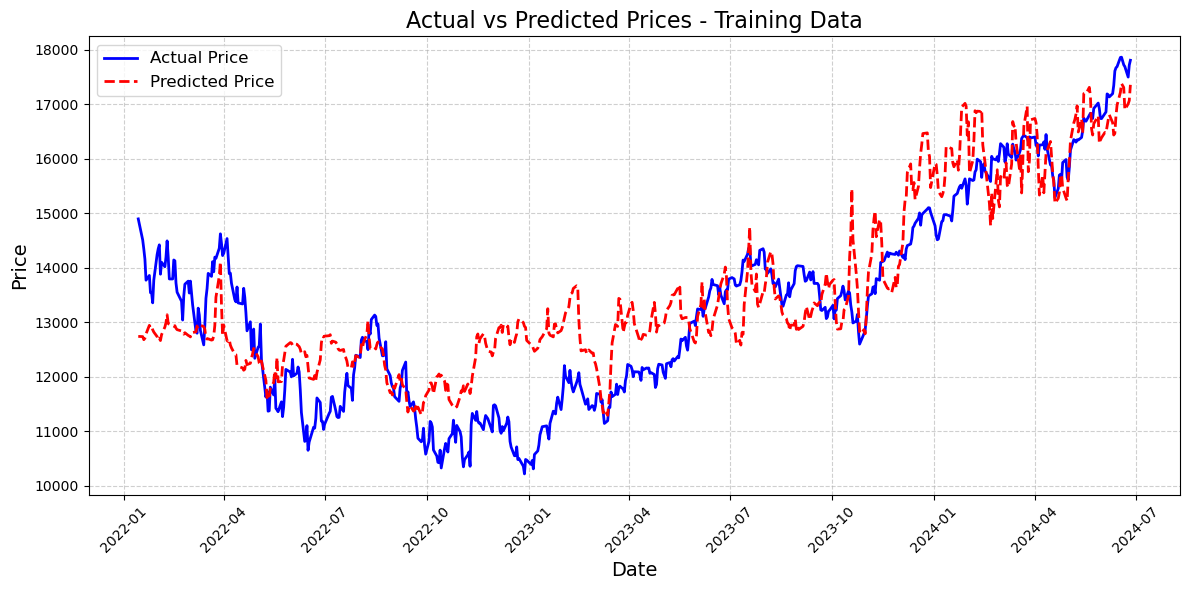

In [96]:
# LSTM Predictions
predictions = model.predict(X_train)

# Karena scaler di-fit pada lebih dari satu kolom, kita hanya inverse transform untuk 'price'
predicted_train = scaler_price.inverse_transform(predictions)

# Ambil tanggal dari train_data, mulai dari tanggal yang sesuai setelah 20 hari (look_back=20)
dates = train_data['Date'].values[look_back - 1:]

# Visualisasi data asli vs prediksi
plt.figure(figsize=(12, 6))

# Plot data harga asli (price) dari train_data
plt.plot(dates, train_data['Price'].values[look_back - 1:], label='Actual Price', color='blue', linewidth=2)

# Plot data harga yang diprediksi oleh model
plt.plot(dates, predicted_train.flatten(), label='Predicted Price', color='red', linestyle='--', linewidth=2)

# Tambahkan detail plot
plt.title('Actual vs Predicted Prices - Training Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Rotasi label tanggal agar lebih mudah dibaca
plt.xticks(rotation=45)
plt.tight_layout()

# Tampilkan plot
plt.show()

2/2 [==============================] - 0s 7ms/step


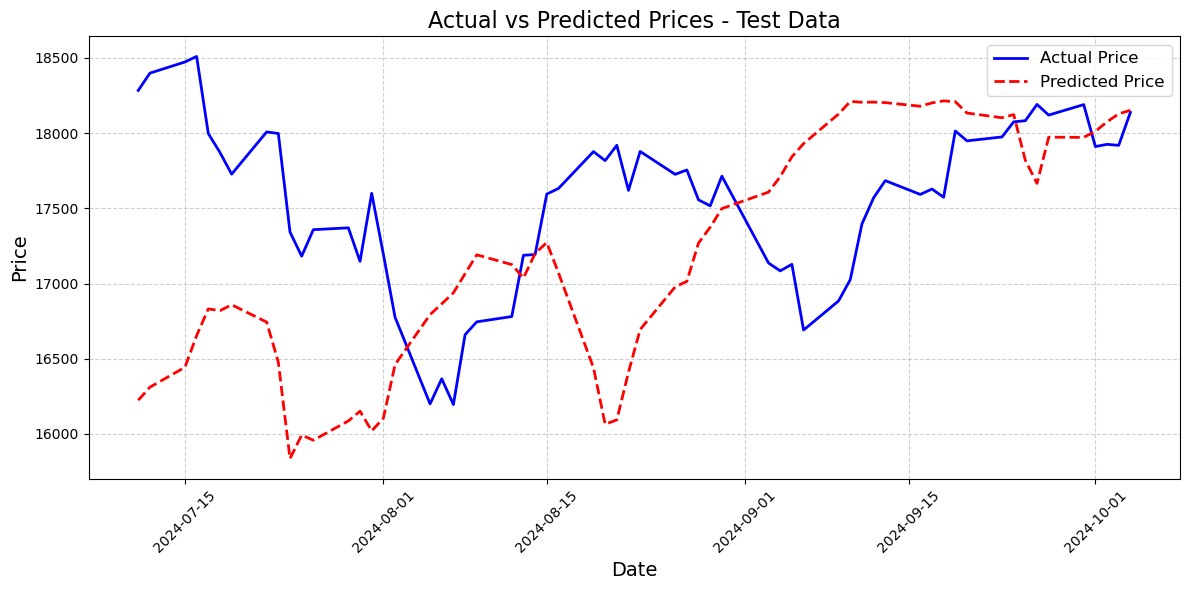

In [97]:
# LSTM Predictions
predictions = model.predict(X_test)

# Karena scaler di-fit pada lebih dari satu kolom, kita hanya inverse transform untuk 'price'
predicted_test = scaler_price.inverse_transform(predictions)

# Ambil tanggal dari train_data, mulai dari tanggal yang sesuai setelah 20 hari (look_back=20)
dates = test_data['Date'].values[look_back - 1:]

# Visualisasi data asli vs prediksi
plt.figure(figsize=(12, 6))

# Plot data harga asli (price) dari train_data
plt.plot(dates, test_data['Price'].values[look_back - 1:], label='Actual Price', color='blue', linewidth=2)

# Plot data harga yang diprediksi oleh model
plt.plot(dates, predicted_test.flatten(), label='Predicted Price', color='red', linestyle='--', linewidth=2)

# Tambahkan detail plot
plt.title('Actual vs Predicted Prices - Test Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Rotasi label tanggal agar lebih mudah dibaca
plt.xticks(rotation=45)
plt.tight_layout()

# Tampilkan plot
plt.show()